# Understanding the in-situ Solar Wind Properties with Machine Learning and Artificial Intelligence

## Clustering Models with the ACE Mission Data

NOTE: This notebook uses the "ACE Mission Cleaned.csv". Please refer to the <a href="../src/01_ACE_Mission_EDA.ipynb"> ACE EDA</a> notebook prior to using this notebook for dataset details and for the CSV file. 

<u><b>Objective:</u></b> <p>Use clustering DBSCAN models to highlight features within the ACE Mission dataset that could be used for pattern recognition when combined in the HCS index data. Due to the limited data available from the HCS index collection, we hope to find additional features that may assist forecast models in accurately predicting HCS variables SD and SL (please refer to the <a href="../src/04_HCS_Sunspots_Reading_EDA.ipynb"> HCS Sunspots Reading </a> notebook for variable details). 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import random

random_state = 4
np.random.seed(random_state)

Import the cleaned ACE Mission data set. Again we will focus on the 4 features related to proton properties. 

In [2]:
df = pd.read_csv("../data/ACE Mission Cleaned.csv").iloc[:, 2:]
df.head()

,proton_density,proton_temp,He4toprotons,proton_speed
0,16.655,9529.1,0.0127,323.90
1,20.601,8757.7,0.0141,322.89
2,18.679,9559.4,0.0087,324.61
3,18.481,8965.9,0.0051,322.68
4,28.315,8329.0,0.0061,321.84


Before clustering we will scale the data once again to avoid over influence by features at a higher scale. 

In [3]:
scaled_df = StandardScaler().fit_transform(df)
scaled_df

array([[ 2.30767916, -1.23428816, -0.90226494, -1.39563749],
       [ 3.15140049, -1.24576392, -0.83554397, -1.40616349],
       [ 2.74044449, -1.2338374 , -1.09289625, -1.38823801],
       ...,
       [ 1.7970845 , -1.18536073,  5.21223455, -0.62202802],
       [ 2.23626433, -1.06578316,  4.14469918, -0.62296598],
       [-0.65176   , -0.87052866, -1.22157239, -0.29478381]])

The function below will iterate through different epsilon values to determine the best value for DBSCAN. Given our dataset is over 121K rows we will sample to reduce calculation time/resources.  

In [4]:
def DBSCAN_scoring(
    min_samples_lst: list, eps_lst: list, X: np.array, metric: str = "euclidean"
):
    eps = []
    min_samples = []
    sil_scores = []
    noise_lst = []
    noise = -1
    num_clusters = []
    db_scores = {}

    for amount in eps_lst:
        if min_samples_lst:
            for sample in min_samples_lst:
                eps.append(amount)
                min_samples.append(sample)
                db_model = DBSCAN(eps=amount, min_samples=sample, metric=metric)
                db_model.fit(X)

                clusters = db_model.labels_
                num_clusters.append(len(np.unique(clusters)))
                if len(np.unique(clusters)) > 1:
                    sil_scores.append(
                        silhouette_score(
                            X,
                            db_model.labels_,
                            random_state=random_state,
                            metric=metric,
                        )
                    )
                else:
                    sil_scores.append(None)
                noise_lst.append(len([i for i in clusters if i == noise]))

        else:
            eps.append(amount)
            min_samples.append(5)
            db_model = DBSCAN(eps=amount, min_samples=5, metric=metric)
            db_model.fit(X)
            clusters = db_model.labels_
            if len(np.unique(clusters)) > 1:
                sil_scores.append(
                    silhouette_score(
                        X, db_model.labels_, random_state=random_state, metric=metric
                    )
                )
            else:
                sil_scores.append(None)

            num_clusters.append(len(np.unique(clusters)))
            noise_lst.append(len([i for i in clusters if i == noise]))

    db_scores["epsilon"] = eps
    db_scores["min_samples"] = min_samples
    db_scores["silhouette_score"] = sil_scores
    db_scores["noise"] = noise_lst
    db_scores["#_clusters"] = num_clusters
    df = pd.DataFrame(db_scores)

    return df

We will use pandas sample to sample from our dataset. First we'll convert the scaled data into a pandas dataframe then sample. 

In [5]:
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121969 entries, 0 to 121968
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   proton_density  121969 non-null  float64
 1   proton_temp     121969 non-null  float64
 2   He4toprotons    121969 non-null  float64
 3   proton_speed    121969 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [6]:
sample_df = scaled_df.sample(frac=0.15, random_state=random_state)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18295 entries, 60638 to 62871
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   proton_density  18295 non-null  float64
 1   proton_temp     18295 non-null  float64
 2   He4toprotons    18295 non-null  float64
 3   proton_speed    18295 non-null  float64
dtypes: float64(4)
memory usage: 714.6 KB


Now we have around 12K rows to iterate. When evaluating the appropriate epsilon value we will look at number of noise data points and silhouette score. The closer to 1.0 for sihouette score the defined the clusters and the less noise data points, the better.  

In [7]:
eps_lst = np.arange(0.1, 1.1, 0.1).tolist()
db_score_df = DBSCAN_scoring(None, eps_lst, sample_df)
db_score_df

,epsilon,min_samples,silhouette_score,noise,#_clusters
0,0.1,5,-0.627849,17615,97
1,0.2,5,-0.586816,5934,89
2,0.3,5,-0.353779,2102,36
3,0.4,5,0.071716,1032,9
4,0.5,5,-0.001235,547,15
5,0.6,5,0.304110,335,8
6,0.7,5,0.296112,240,6
7,0.8,5,0.480025,160,5
8,0.9,5,0.420209,120,6
9,1.0,5,0.429544,75,3


Based on our 15% sample, it appears the closer to 1 epsilon, the stronger the clusters. This could also indicate our data points are too close together for DBSCAN to find a meaningful pattern. Let's fit a DBSCAN model to our data with epsilon set to 0.8 (since that is the highest silhouette score). Then we'll plot a simple bar chart for our clusters to see how they distribute.

In [8]:
DB_model1 = DBSCAN(eps=0.8, min_samples=5)
DB_model1.fit(scaled_df)

DBSCAN(eps=0.8)

Now we'll take the full ACE Mission dataset and apply cluster labels from our model. 

In [9]:
# copy ACE Mission dataframe for label classification.
DBSCAN_df = df.copy()
DBSCAN_df["Cluster"] = DB_model1.labels_

The following function will take our DB_model dataframe and plot a bar chart showing cluster distribution. 

In [10]:
def plot_cluster_dist(df: pd.DataFrame):
    plot_dic = {}
    clusters = []
    data_counts = []

    for c in np.sort(df.Cluster.unique()).tolist():
        clusters.append(c)
        data_counts.append(len(df[df.Cluster == c]))
        plot_dic[c] = len(df[df.Cluster == c])

    plot_dic["clusters"] = clusters
    plot_dic["# of pts"] = data_counts

    plot_df = pd.DataFrame(plot_dic)

    fig, ax = plt.subplots(figsize=(30, 15))

    annotations = plot_df["# of pts"].tolist()
    ax.bar(plot_df["clusters"], plot_df["# of pts"])
    # ax.setxticks()
    for xi, yi, text in zip(plot_df["clusters"], plot_df["# of pts"], annotations):
        ax.annotate(
            text,
            xy=(xi, yi),
            xycoords="data",
            xytext=(-5, 5),
            textcoords="offset points",
        )

    return plt.show()

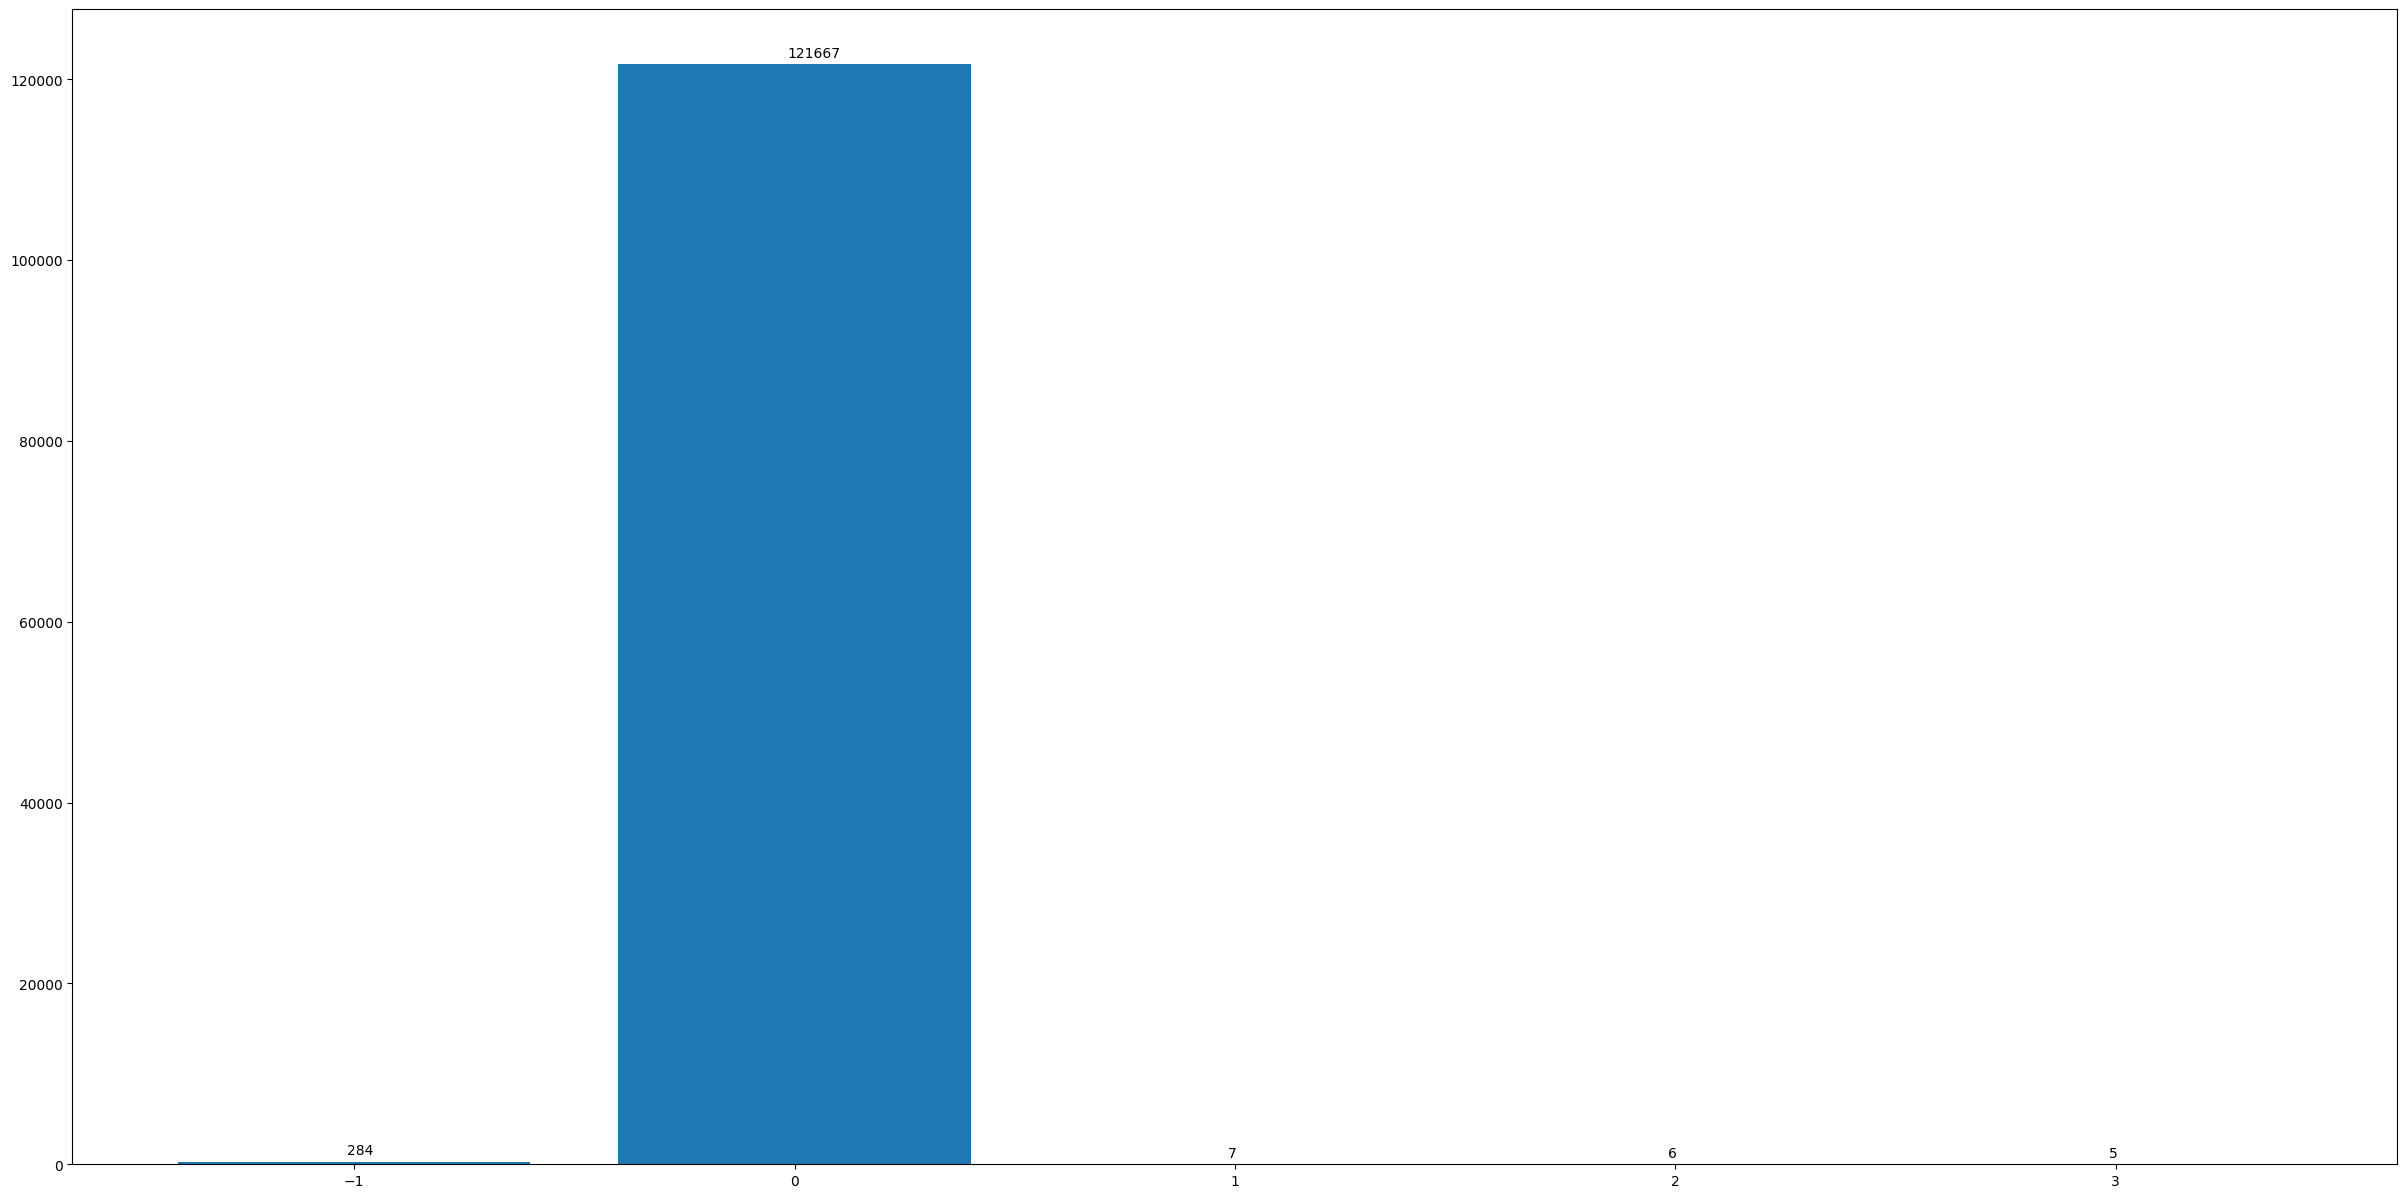

In [11]:
plot_cluster_dist(DBSCAN_df)

Unfortunately out of the 121969 data points, 121667 are classified in one cluster. To double check that our epsilon value should be different, we can calculate the K nearest neighbors for each data point and plot to see the epsilon value that occurs at the bend in the curve. If this epsilon appears to be different than our initial assumption, we will review the distribution again. 

Reference: <a href="https://sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/">How to Determine Epsilon and minpts Parameters of DBSCAN Clustering</a>

In [12]:
# calculating each data point to it's nearest neighbor

from sklearn.neighbors import NearestNeighbors

# we want 5 nearest neighbors since we are using minpts=5 in DBSCAN.
neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(scaled_df)
distances, indices = neighbors.kneighbors(scaled_df)

In [13]:
distances.shape

(121969, 5)

Text(0, 0.5, '5-NN distance')

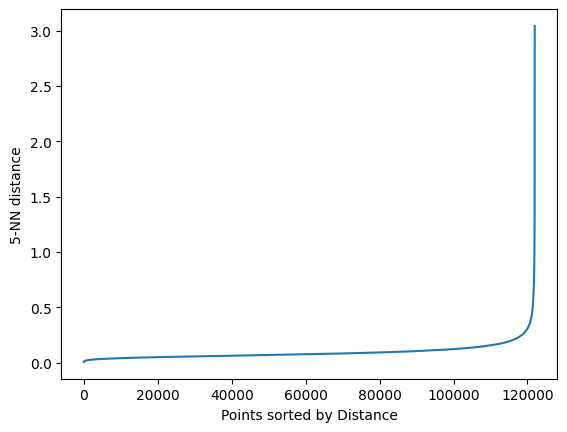

In [14]:
sort_distances = np.sort(distances, axis=0)
sorted_distances = sort_distances[:, 1]
plt.plot(sorted_distances)
plt.xlabel("Points sorted by Distance")
plt.ylabel("5-NN distance")

According to the plot an epsilon just under 0.5 is most appropriate. We will fit the model to 0.4 for epsilon and review the results. 

In [15]:
DB_model2 = DBSCAN(eps=0.4, min_samples=5)
DB_model2.fit(scaled_df)
# copy ACE Mission dataframe for label classification.
DBSCAN_df2 = df.copy()
DBSCAN_df2["Cluster"] = DB_model2.labels_

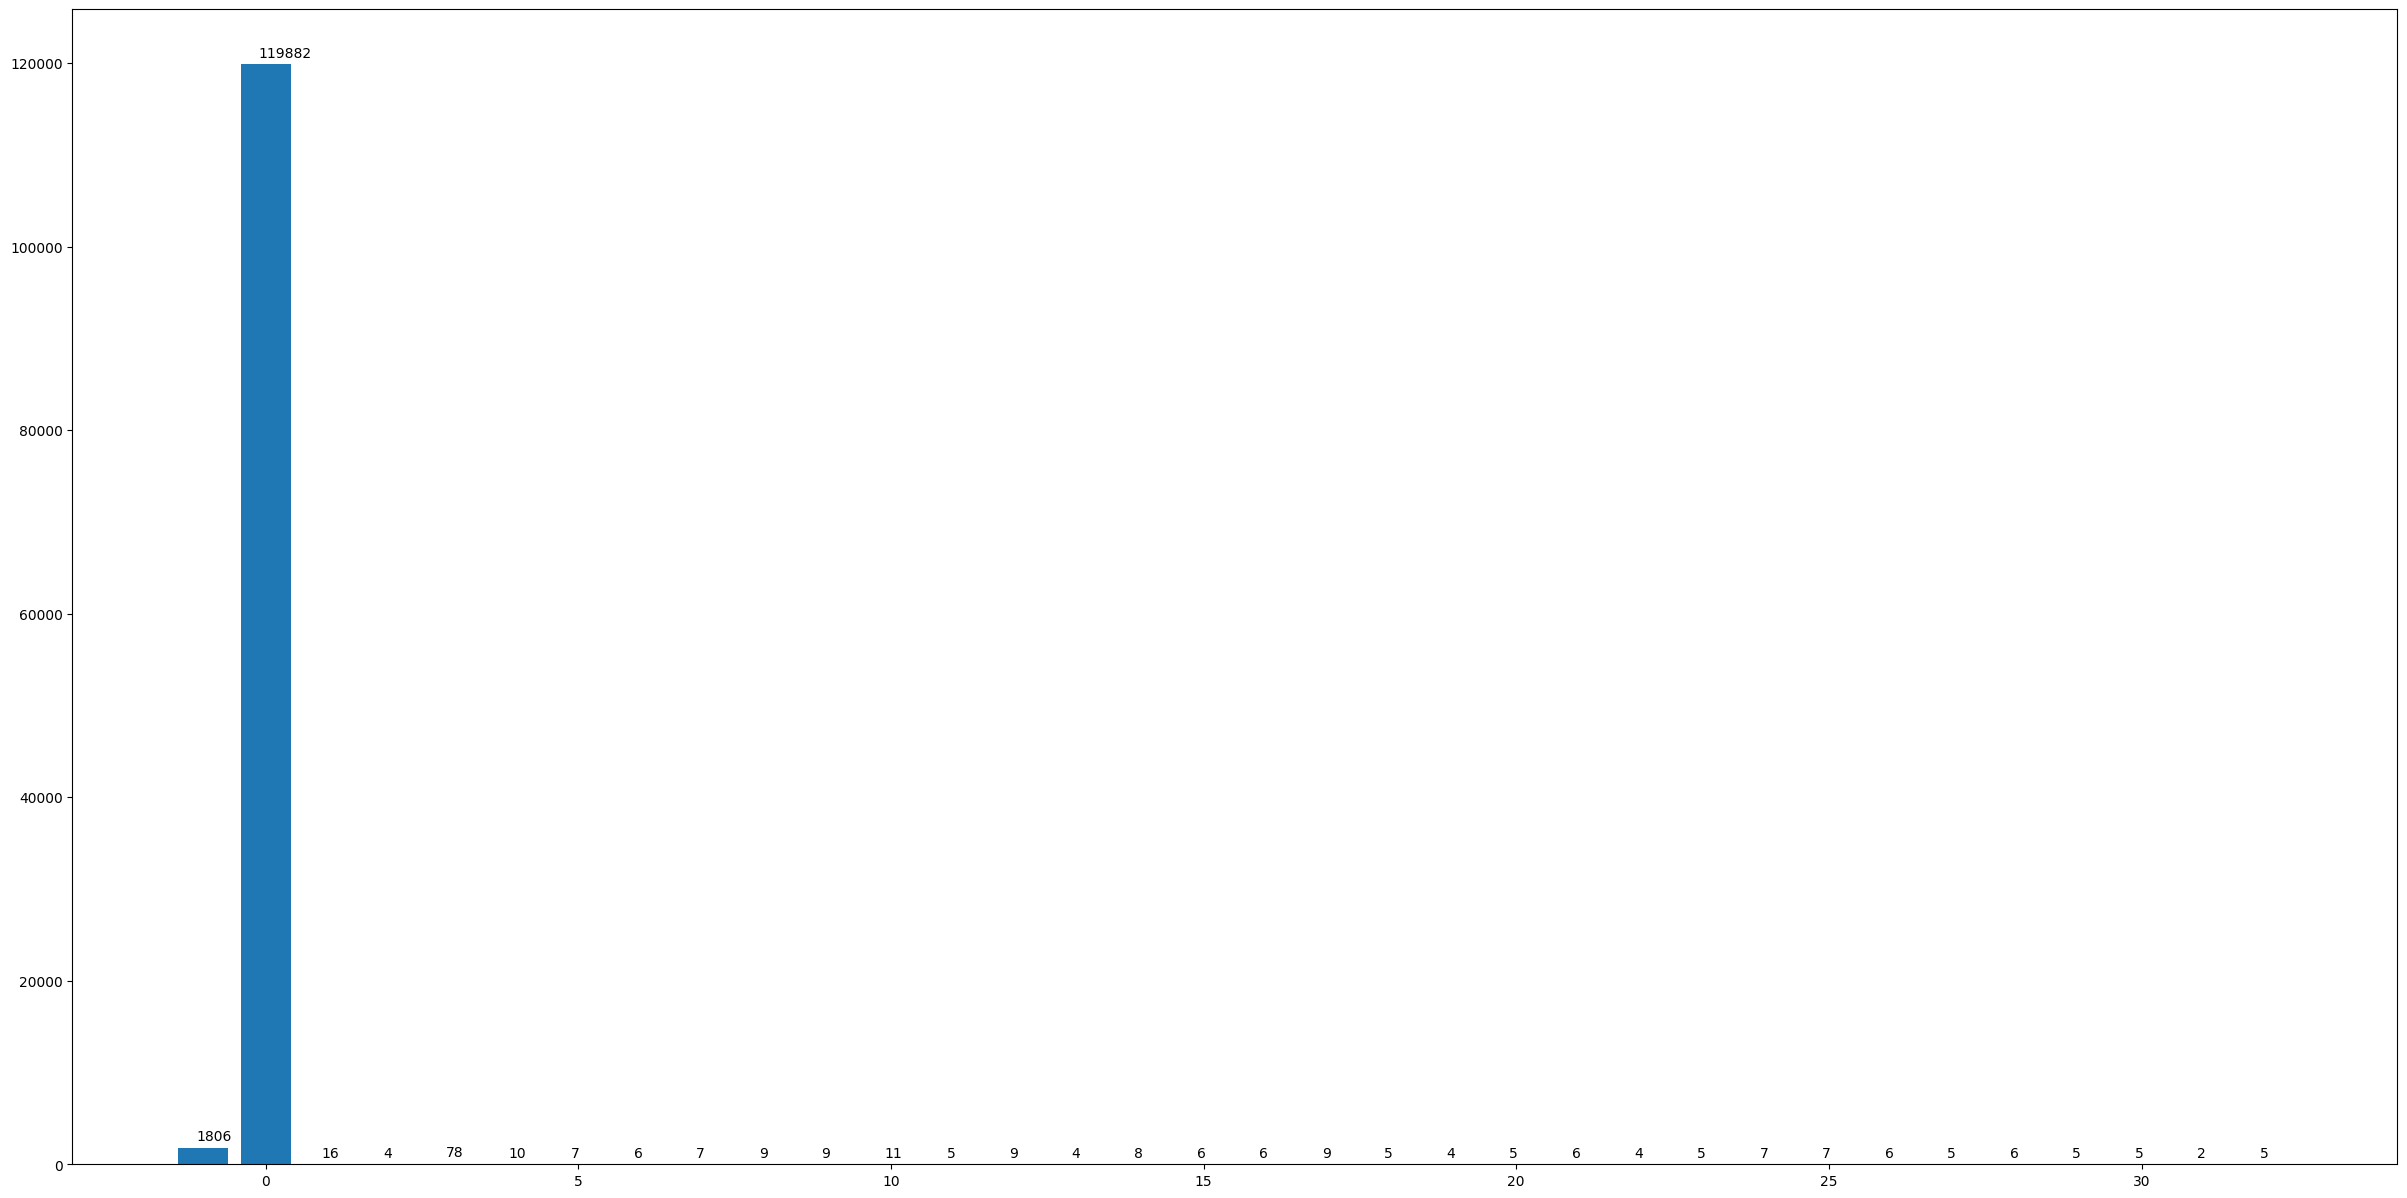

In [16]:
plot_cluster_dist(DBSCAN_df2)

According to our distribution we still get the majority of points in one cluster with only a few scattered across others. Here we see DBSCAN will be unable to provide insight into feature importance for the ACE Mission data. 

Given this we will move onto the HCS Index data and modeling. Please proceed to the <a href="../src/04_HCS_Sunspots_Reading_EDA.ipynb">HCS Sunspots Reading</a> notebook. 